<a href="https://colab.research.google.com/github/alyjee/ensemble-learning/blob/main/Ensemble_learning_Inpainting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Image Impainting - Deep Image Prior**

Demonstration for **"Inpainting"** using DIP.
DIP: Deep image prior is a type of convolutional neural network used to enhance a given image with no prior training data other than the image itself.

Read more [here](https://en.wikipedia.org/wiki/Deep_image_prior).


Code for **"Inpainting"**


In [1]:
"""
*Uncomment if running on colab* 
Set Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab 
"""
import os
if (os.path.exists("./ensemble-learning")):
  print("You have already cloned the code, skipping the step.")

else:
  !git clone https://github.com/alyjee/ensemble-learning.git
  !mv ensemble-learning/* ./.
  !gdown "https://drive.google.com/u/0/uc?id=1uMghKl883-9hDLhSiI8lRbHCzCmmRwV-&export=download"
  !mv /content/deepfillv2_WGAN_G_epoch40_batchsize4.pth deepfillv2_colab/model/deepfillv2_WGAN.pth


Cloning into 'ensemble-learning'...
remote: Enumerating objects: 105, done.
remote: Counting objects: 100% (105/105), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 105 (delta 19), reused 103 (delta 17), pack-reused 0
Receiving objects: 100% (105/105), 3.70 MiB | 5.41 MiB/s, done.
Resolving deltas: 100% (19/19), done.
Downloading...
From: https://drive.google.com/u/0/uc?id=1uMghKl883-9hDLhSiI8lRbHCzCmmRwV-&export=download
To: /content/deepfillv2_WGAN_G_epoch40_batchsize4.pth
100% 64.8M/64.8M [00:00<00:00, 72.3MB/s]


## Import libs

In [2]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import shutil

import numpy as np
from models.resnet import ResNet
from models.unet import UNet
from models.skip import skip
import torch
import torch.optim

from utils.inpainting_utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

PLOT = True
imsize = -1
dim_div_by = 64

## Choose figure

In [3]:
## Fig 6
img_path  = 'data/inpainting/vase.png'
mask_path = 'data/inpainting/vase_mask.png'

## Fig 8
# img_path  = 'data/inpainting/library.png'
# mask_path = 'data/inpainting/library_mask.png'

## Fig 7 (top)
# img_path  = 'data/inpainting/kate.png'
# mask_path = 'data/inpainting/kate_mask.png'

NET_TYPE = 'skip_depth6' # one of skip_depth4|skip_depth2|UNET|ResNet

## Load mask

In [4]:
img_pil, img_np = get_image(img_path, imsize)
img_mask_pil, img_mask_np = get_image(mask_path, imsize)

### Center crop

In [5]:
img_mask_pil = crop_image(img_mask_pil, dim_div_by)
img_pil      = crop_image(img_pil,      dim_div_by)

img_np      = pil_to_np(img_pil)
img_mask_np = pil_to_np(img_mask_pil)

### Visualize Images for Deep Image Prior

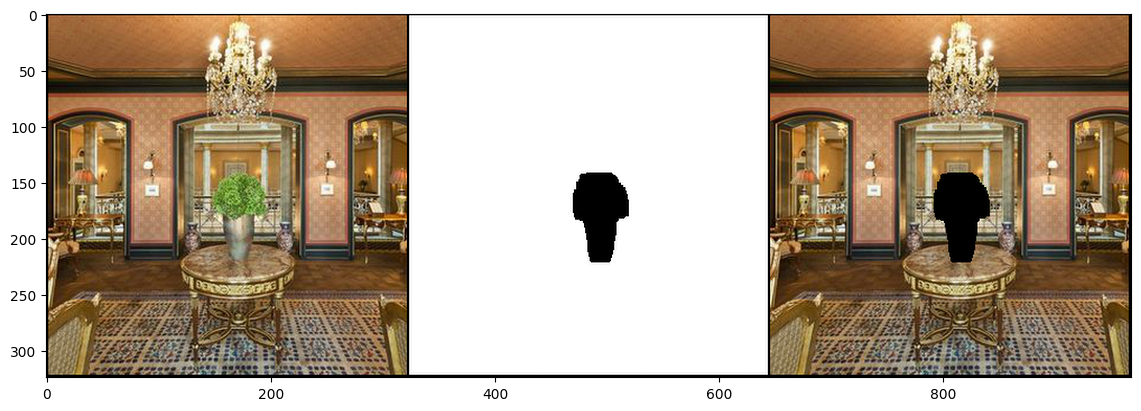

In [6]:
img_mask_var = np_to_torch(img_mask_np).type(dtype)

plot_image_grid([img_np, img_mask_np, img_mask_np*img_np], 3,11);

## Setup

In [7]:
pad = 'reflection' # 'zero'
OPT_OVER = 'net'
OPTIMIZER = 'adam'

In [8]:
if 'vase.png' in img_path:
    INPUT = 'meshgrid'
    input_depth = 2
    LR = 0.01 
    num_iter = 5001
    param_noise = False
    show_every = 50
    figsize = 5
    reg_noise_std = 0.03
    
    net = skip(input_depth, img_np.shape[0], 
               num_channels_down = [128] * 5,
               num_channels_up   = [128] * 5,
               num_channels_skip = [0] * 5,  
               upsample_mode='nearest', filter_skip_size=1, filter_size_up=3, filter_size_down=3,
               need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)
    
elif ('kate.png' in img_path) or ('peppers.png' in img_path):
    # Same params and net as in super-resolution and denoising
    INPUT = 'noise'
    input_depth = 32
    LR = 0.01 
    num_iter = 6001
    param_noise = False
    show_every = 50
    figsize = 5
    reg_noise_std = 0.03
    
    net = skip(input_depth, img_np.shape[0], 
               num_channels_down = [128] * 5,
               num_channels_up =   [128] * 5,
               num_channels_skip =    [128] * 5,  
               filter_size_up = 3, filter_size_down = 3, 
               upsample_mode='nearest', filter_skip_size=1,
               need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)
    
elif 'library.png' in img_path:
    
    INPUT = 'noise'
    input_depth = 1
    
    num_iter = 3001
    show_every = 50
    figsize = 8
    reg_noise_std = 0.00
    param_noise = True
    
    if 'skip' in NET_TYPE:
        
        depth = int(NET_TYPE[-1])
        net = skip(input_depth, img_np.shape[0], 
               num_channels_down = [16, 32, 64, 128, 128, 128][:depth],
               num_channels_up =   [16, 32, 64, 128, 128, 128][:depth],
               num_channels_skip =    [0, 0, 0, 0, 0, 0][:depth],  
               filter_size_up = 3,filter_size_down = 5,  filter_skip_size=1,
               upsample_mode='nearest', # downsample_mode='avg',
               need1x1_up=False,
               need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)
        
        LR = 0.01 
        
    elif NET_TYPE == 'UNET':
        
        net = UNet(num_input_channels=input_depth, num_output_channels=3, 
                   feature_scale=8, more_layers=1, 
                   concat_x=False, upsample_mode='deconv', 
                   pad='zero', norm_layer=torch.nn.InstanceNorm2d, need_sigmoid=True, need_bias=True)
        
        LR = 0.001
        param_noise = False
        
    elif NET_TYPE == 'ResNet':
        
        net = ResNet(input_depth, img_np.shape[0], 8, 32, need_sigmoid=True, act_fun='LeakyReLU')
        
        LR = 0.001
        param_noise = False
        
    else:
        assert False
else:
    assert False

net = net.type(dtype)
net_input = get_noise(input_depth, INPUT, img_np.shape[1:]).type(dtype)

In [9]:
# Compute number of parameters
s  = sum(np.prod(list(p.size())) for p in net.parameters())
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

img_var = np_to_torch(img_np).type(dtype)
mask_var = np_to_torch(img_mask_np).type(dtype)

Number of params: 2157955


## Main loop

Starting optimization with ADAM


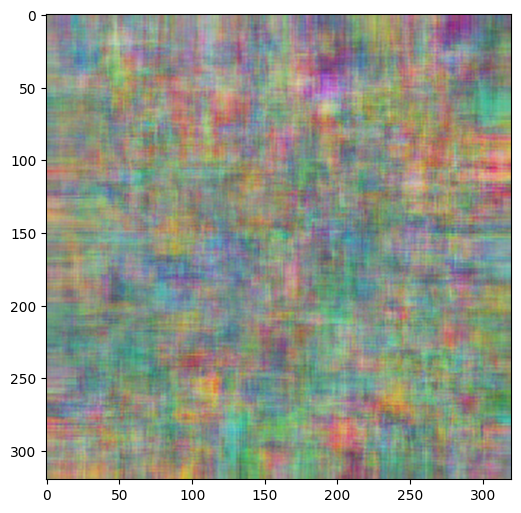

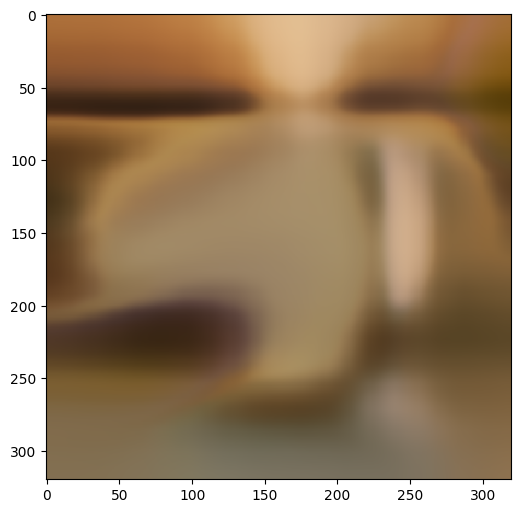

In [13]:
i = 0
def closure():
    
    global i
    
    if param_noise:
        for n in [x for x in net.parameters() if len(x.size()) == 4]:
            n = n + n.detach().clone().normal_() * n.std() / 50
    
    net_input = net_input_saved
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
        
        
    out = net(net_input)
   
    total_loss = mse(out * mask_var, img_var * mask_var)
    total_loss.backward()
        
    print ('Iteration %05d    Loss %f' % (i, total_loss.item()), '\r', end='')
    if  PLOT and i % show_every == 0:
        out_np = torch_to_np(out)
        plot_image_grid([np.clip(out_np, 0, 1)], factor=figsize, nrow=1)
        
    i += 1

    return total_loss

net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

# less iterations
num_iter = 100

p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

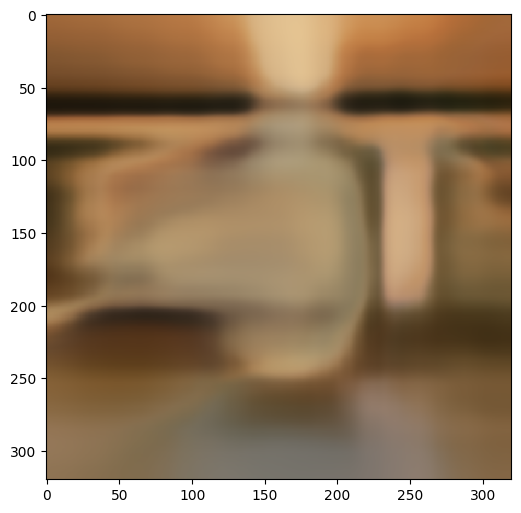

In [14]:
out_np = torch_to_np(net(net_input))
plot_image_grid([out_np], factor=5);

# **DEEPFILL DEMONSTRATION**

Colab code for image inpainting.
  

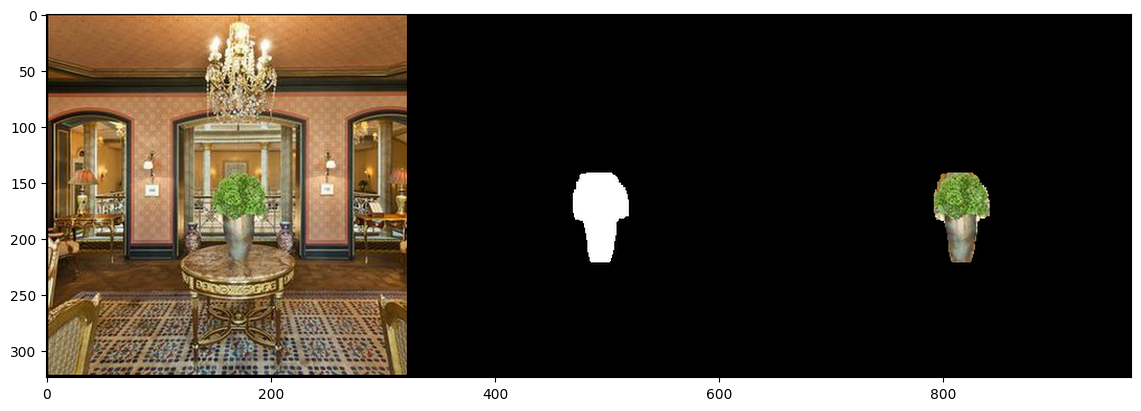

In [10]:
#@title Invert mask for Deep Fill and visualize { display-mode: "form" }

df_image_dest_path = "/content/deepfillv2_colab/input/input_img.png"
df_mask_dest_path = "/content/deepfillv2_colab/input/mask.png"

# Invert mask image colors and save it
from PIL import Image
import PIL.ImageOps
original_mask_image = Image.open(mask_path)
inverted_mask_image = PIL.ImageOps.invert(original_mask_image)
inverted_mask_image.save(df_mask_dest_path)

# Save input image at DF destination
shutil.copy(img_path, df_image_dest_path)

# Load images
df_img_pil, df_img_np = get_image(df_image_dest_path, imsize)
df_img_mask_pil, df_img_mask_np = get_image(df_mask_dest_path, imsize)

# Center Crop
df_img_mask_pil = crop_image(df_img_mask_pil, dim_div_by)
df_img_pil      = crop_image(df_img_pil,      dim_div_by)

df_img_np      = pil_to_np(df_img_pil)
df_img_mask_np = pil_to_np(df_img_mask_pil)

plot_image_grid([df_img_np, df_img_mask_np, df_img_np*df_img_mask_np], 3, 11)


NET_TYPE = 'skip_depth6' # one of skip_depth4|skip_depth2|UNET|ResNet

## **INPAINT using DeepFill !!**

In [11]:
#@title Run to trigger inpainting. { display-mode: "form" }
%cd deepfillv2_colab
!python inpaint.py
%cd ../

/content/deepfillv2_colab
-- Generator is created! --
-- Initialized generator with xavier type --
-- INPAINT: Loading Pretrained Model --
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
-- Inpainting is finished --
/content


## **DeepFill Input/Output COMPARISION**

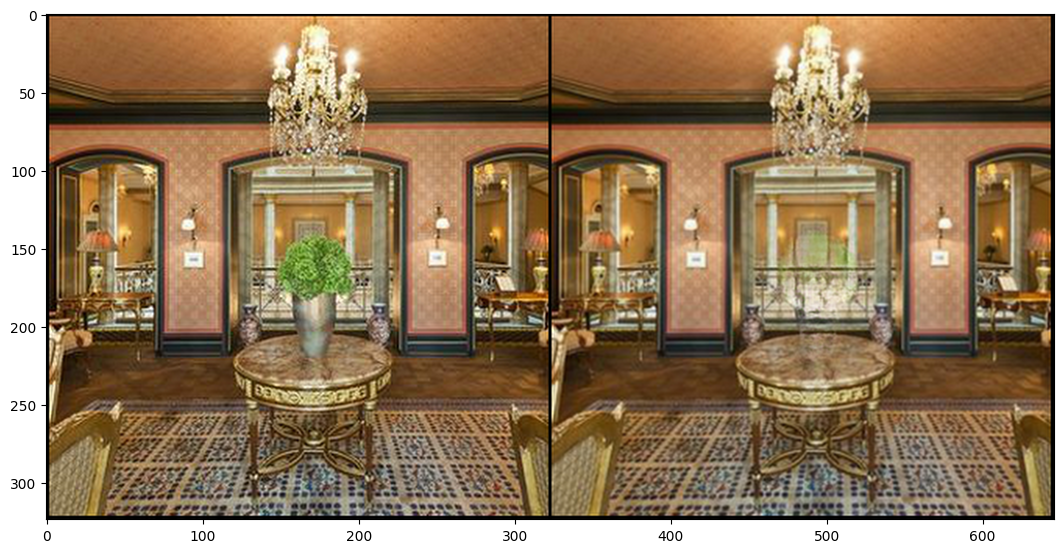

In [12]:
deepFillInputImagePath ="/content/deepfillv2_colab/input/input_img.png"
deepFillOutputImage ="/content/deepfillv2_colab/output/inpainted_img.png"
resize = 320
deepFillInputImagePill, deepFillInputImageNP = get_image(deepFillInputImagePath, resize)
deepFillOutputImagePill, deepFillOutputImageNP = get_image(deepFillOutputImage, resize)
plot_image_grid([deepFillInputImageNP, deepFillOutputImageNP], 2, 11);

# **Ensemble learning**
  

## **Results Comparison DIP vs DeepFill**

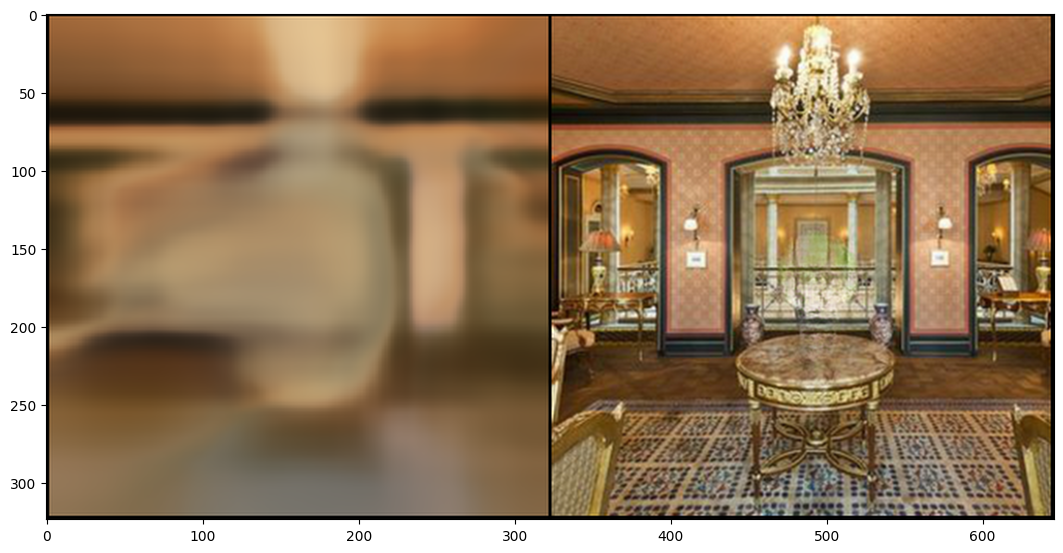

In [16]:
dipOutputImage = out_np
deepFillOutputImage ="/content/deepfillv2_colab/output/inpainted_img.png"
resize = 320
deepFillOutputImagePill, deepFillOutputImageNP = get_image(deepFillOutputImage, resize)
plot_image_grid([out_np, deepFillOutputImageNP], 2, 11);

## **Merge Predictions and Draw Image**



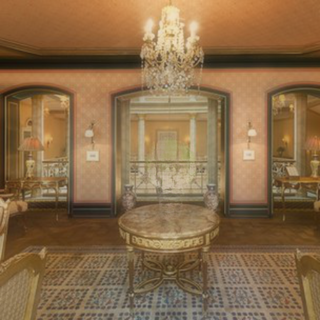

In [17]:
# Blend the predictions
try:
    inpainted_image_dip = out_np
except NameError:
    print("Error: No output image found for DIP, maybe you forgot to run DIP!")

try:
    inpainted_image_deepfill = deepFillOutputImageNP
except NameError:
  print("Error: No output image found for DeepFill, maybe you forgot to run DeepFill Inpainting!")

inpainted_image_ensemble = (inpainted_image_dip + inpainted_image_deepfill) / 2

# Convert the inpainted image tensor to numpy array
np_to_pil(inpainted_image_ensemble)